In [98]:
import pandas as pd
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.preprocessing as prep
import sklearn.impute as imp
import datetime
from scipy import stats

from sklearn.cluster import KMeans 
from sklearn import metrics 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture

In [19]:
pva = pd.read_csv('donors.csv')

In [20]:
pva.head()

,Unnamed: 0,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,...,AVGGIFT,CONTROLN,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,0,2009-01-01,GRI,0,IL,61081,,,1957-12-01,0,...,7.741935,95515,0,L,4,E,X,X,X,C
1,1,2014-01-01,BOA,1,CA,91326,,,1972-02-01,0,...,15.666667,148535,0,L,2,G,X,X,X,A
2,2,2010-01-01,AMH,1,NC,27017,,,NaN,0,...,7.481481,15078,1,L,4,E,X,X,X,C
3,3,2007-01-01,BRY,0,CA,95953,,,1948-01-01,0,...,6.812500,172556,1,L,4,E,X,X,X,C
4,4,2006-01-01,,0,FL,33176,,,1940-01-01,0,...,6.864865,7112,1,L,2,F,X,X,X,A


In [21]:
pva.dtypes.value_counts()

int64      302
object     125
float64     49
dtype: int64

In [22]:
del pva['Unnamed: 0']
pva.dtypes

ODATEDW     object
OSOURCE     object
TCODE        int64
STATE       object
ZIP         object
             ...  
RFA_2A      object
MDMAUD_R    object
MDMAUD_F    object
MDMAUD_A    object
GEOCODE2    object
Length: 475, dtype: object

In [23]:
# Cheecking for duplicates
pva.duplicated().sum()

0

# Feature Engineering

In [24]:
#Getting the donor's age from their date-of-birth
pva['DOB'] = pd.to_datetime(pva.DOB)

def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [25]:
pva['DOB'] = pva['DOB'].apply(lambda x: from_dob_to_age(x))
pva.rename({'DOB': 'Age'}, axis=1, inplace=True)

# Data Exploration

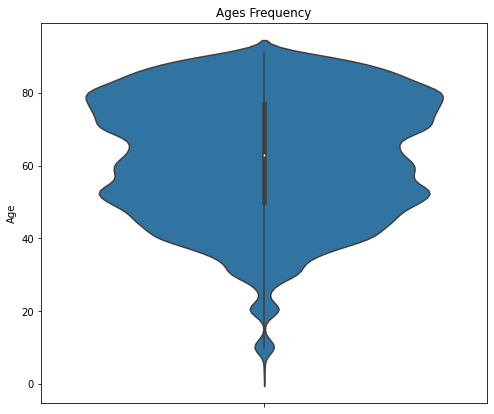

In [26]:
plt.figure(figsize=(8,7))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=pva["Age"])
plt.show()

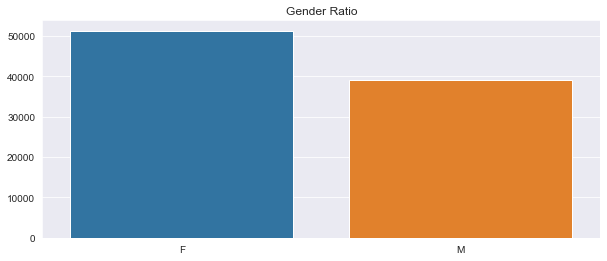

In [29]:
genders = pva.GENDER.value_counts().head(2)
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.title('Gender Ratio')
plt.show()

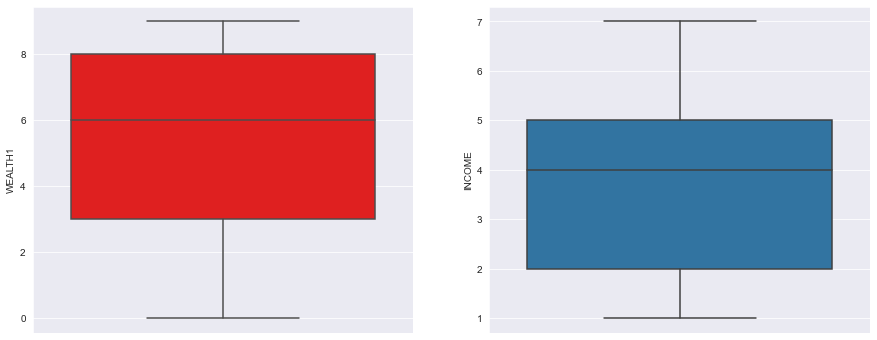

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=pva["WEALTH1"], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=pva["INCOME"])
plt.show()

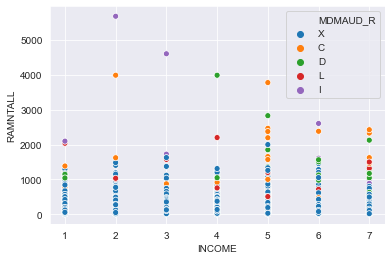

In [31]:
sns.scatterplot(data=pva, x="INCOME", y="RAMNTALL",hue="MDMAUD_R")

C=Current Donor (Major)
L=Lapsed Donor (Major)
I=Inactive Donor (Major)
D=Dormant Donor (Major)
X=Not Major Donor

##### Surprisingly the people with the biggest $ amount of lifetime gifts don't have high incomes.

# Redundancy and Relevancy

In [56]:
corr_matrix = pva.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop

['POP902',
 'POP903',
 'ETH13',
 'AGE902',
 'AGE903',
 'AGE904',
 'AGE905',
 'AGE906',
 'HHAGE1',
 'HHAGE3',
 'HHN4',
 'HHN6',
 'MARR3',
 'HHP1',
 'HHP2',
 'DW2',
 'DW5',
 'DW6',
 'HV2',
 'HV4',
 'HU2',
 'HHD1',
 'HHD3',
 'HHD4',
 'HHD5',
 'HHD9',
 'HHD11',
 'ETHC4',
 'ETHC5',
 'HVP1',
 'HVP2',
 'HVP4',
 'HVP6',
 'RHP1',
 'RHP2',
 'RHP3',
 'HUPA2',
 'HUPA6',
 'RP1',
 'RP2',
 'IC2',
 'IC3',
 'IC4',
 'IC19',
 'IC20',
 'IC21',
 'IC22',
 'IC23',
 'HHAS1',
 'TPE4',
 'LFC2',
 'LFC3',
 'LFC4',
 'LFC5',
 'EIC1',
 'AFC2',
 'AFC5',
 'LSC2',
 'HC8',
 'HC18',
 'NUMPROM',
 'RAMNT_4',
 'RAMNT_5',
 'RAMNT_6',
 'RAMNT_7',
 'RAMNT_8',
 'RAMNT_9',
 'RAMNT_13',
 'RAMNT_14',
 'RAMNT_15',
 'RAMNT_16',
 'RAMNT_17',
 'RAMNT_19',
 'RAMNT_21',
 'RAMNT_24',
 'CARDGIFT',
 'LASTGIFT']

In [57]:
pva.drop(to_drop,axis=1,inplace=True)

In [58]:
#We found sever incoherence in the datetime variables and no usefulness in them for customer segmentation
del pva['ODATEDW']
del pva['MAXADATE']
del pva['MINRDATE']
del pva['MAXRDATE']
del pva['LASTDATE']
del pva['FISTDATE']
del pva['NEXTDATE']

In [59]:
#After a carefull inspection of these variables we decided to delete them
del pva['MAILCODE']
del pva['PVASTATE']
del pva['NOEXCH']

###    Acessing missing values

In [60]:
pva.NUMCHLD = pva.NUMCHLD.fillna(0)

#Replacing NaNs in the RAMNT_# variables by 0
pva.loc[:, 'RAMNT_3':'RAMNT_24'] = pva.loc[:, 'RAMNT_3':'RAMNT_24'].fillna(0)

In [61]:
pva['HOMEOWNR'] = pva['HOMEOWNR'].str.replace(' ', '0')
pva['HOMEOWNR'] = pva['HOMEOWNR'].str.replace('U', '0')
pva['HOMEOWNR'] = pva['HOMEOWNR'].str.replace('H', '1')

In [62]:
pva['GENDER'] = pva['GENDER'].str.replace(' ','U')
pva['GENDER'] = pva['GENDER'].str.replace('A', 'U')
pva['GENDER'] = pva['GENDER'].str.replace('C', 'U')
pva['GENDER'] = pva['GENDER'].str.replace('J', 'U')

In [63]:
def replaceX(a_column):
    pva[a_column] = pva[a_column].str.replace('X','1')
    pva[a_column] = pva[a_column].str.replace(' ','0')

In [64]:
def replaceY(a_column):
    pva[a_column] = pva[a_column].str.replace('Y','1')
    pva[a_column] = pva[a_column].str.replace(' ','0')

In [65]:
#For some of the categorical variales the transition for metric was this easy
replaceX('RECINHSE')
replaceX('RECP3')
replaceX('RECPGVG')
replaceX('RECSWEEP')
replaceX('MAJOR')
replaceX('PEPSTRFL')

In [66]:
interests = pva.iloc[:, 48:66].columns
for column in interests:
    replaceY(column)

In [67]:
pva['MDMAUD_R'] = pva['MDMAUD_R'].str.replace('X','0')
pva['MDMAUD_F'] = pva['MDMAUD_F'].str.replace('X','0')
pva['MDMAUD_A'] = pva['MDMAUD_A'].str.replace('X','0')

In [68]:
# Finding the percentage of NaN's in each column
percent_missing = pva.isnull().sum() * 100 / len(pva)
missing_value = pd.DataFrame({'Column Name': pva.columns,'Percentage Missing': percent_missing})
missing_value.sort_values('Percentage Missing', inplace=True)
# Printing the top 10 columns with biggest NaN values percentage
print(missing_value.tail(10))

         Column Name  Percentage Missing
RAMNT_20    RAMNT_20           91.732696
RDATE_20    RDATE_20           91.732696
RDATE_23    RDATE_23           91.763091
RAMNT_23    RAMNT_23           91.763091
RDATE_15    RDATE_15           92.388798
RDATE_6      RDATE_6           99.186685
RDATE_4      RDATE_4           99.705488
RAMNT_3      RAMNT_3           99.746363
RDATE_3      RDATE_3           99.746363
RDATE_5      RDATE_5           99.990567


In [69]:
missing50plus = missing_value.tail(48)

In [70]:
# Dropping Columns with >50% Nans
pva.drop(missing50plus['Column Name'], axis=1, inplace=True)

In [71]:
adate = pva.iloc[:, 279:299]
#Dropping ADATE_# columns
pva.drop(list(adate.columns.values), axis=1, inplace=True)

In [72]:
def find_missing(df):
    missing_col = df.columns[df.isna().sum()>0]
    col_missing_val = df[missing_col].isna().sum().sort_values(ascending=False)
    per_missing_val = (df[missing_col].isna().sum()/df.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.DataFrame(col_missing_val,columns=['missing_number'])
    missing_df['missing_percentage']=per_missing_val
    print('Number of columns with missing data:',missing_df.shape[0])
    return missing_df

In [73]:
find_missing(pva)

Number of columns with missing data: 8


,missing_number,missing_percentage
WEALTH2,43823,45.930281
Age,23883,25.031443
INCOME,21286,22.309563
TIMELAG,9973,10.452564
GEOCODE2,132,0.138347
DMA,132,0.138347
ADI,132,0.138347
MSA,132,0.138347


Before imputing values on these variables we should first look at the missing values per row/ donor.

#### Missing values per row

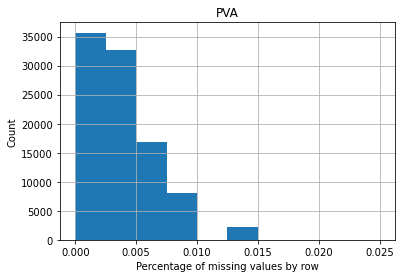

In [74]:
(pva.isnull().sum(axis=1)/pva.shape[1]).sort_values(ascending=False).hist()
plt.xlabel('Percentage of missing values by row')
plt.ylabel('Count')
plt.title('PVA');

Since there isn't a clear major lack of data from the donors we conclude that it is possible to proceed for the imputing.

#### Imputation

In [75]:
# Splitting feature names into groups
non_metric_features = pva.select_dtypes(include=['object']).columns
metric_features = pva.select_dtypes(exclude=['object']).columns

pva_metric = pva[metric_features]
pva_non_metric = pva[non_metric_features]

In [76]:
# Checking that no variable is left behind
len(metric_features) + len(non_metric_features) == len(pva.columns)

True

One popular technique for imputation is a K-nearest neighbor model. A new sample is imputed by finding the samples in the training set “closest” to it and averages these nearby points to fill in the value

In [77]:
#For usage of the KNN imputer it makes sense to standarize our metric data

std = prep.StandardScaler()
std.fit(pva_metric)
std_m_df = std.transform(pva_metric)

In [78]:
# KNN imputer for metric variables

imputer = imp.KNNImputer(n_neighbors=50, weights="distance")
imputted_m = imputer.fit_transform(std_m_df)
pva_imp_m = pd.DataFrame(imputted_m,columns = pva_metric.columns)

In [79]:
# Mode imputer for non metric variables

imputer_nm = imp.SimpleImputer(strategy="most_frequent")
imputer_nm.fit(pva_non_metric)
imputted_nm = imputer_nm.transform(pva_non_metric)
pva_imp_nm = pd.DataFrame(imputted_nm, columns = pva_non_metric.columns)

In [80]:
pva_imp_nm.to_csv('imputted_nm.csv',sep=';',index=False)
pva_imp_m.to_csv('imputted_m.csv',sep=';',index=False)

In [81]:
pva_i = pd.concat([pva_imp_m, pva_imp_nm], axis=1)

In [82]:
find_missing(pva_i)

Number of columns with missing data: 0


,missing_number,missing_percentage


#### Encoding categorical variables

In [84]:
# Load imputted data frames
pva_imp_nm = pd.read_csv('imputted_nm.csv', sep=';')
pva_imp_m = pd.read_csv('imputted_m.csv', sep=';')

In [85]:
pva_i = pd.concat([pva_imp_m, pva_imp_nm], axis=1)

In [86]:
pva_imp_nm.head()

,OSOURCE,STATE,ZIP,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,HOMEOWNR,...,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
0,GRI,IL,61081,0,0,0,0,XXXX,T2,0,...,S4E,S4E,S4E,S4E,L,E,0,0,0,C
1,BOA,CA,91326,0,0,0,0,XXXX,S1,1,...,N1E,N1E,,F1E,L,G,0,0,0,A
2,AMH,NC,27017,0,0,0,0,XXXX,R2,0,...,,S4D,S4D,S3D,L,E,0,0,0,C
3,BRY,CA,95953,0,0,0,0,XXXX,R2,0,...,A1D,A1D,,,L,E,0,0,0,C
4,,FL,33176,1,1,0,0,XXXX,S2,1,...,A3D,I4E,A3D,A3D,L,F,0,0,0,A


In [87]:
# Splitting feature names into groups
i_non_metric_features = pva_i.select_dtypes(include=['object']).columns
i_metric_features = pva_i.select_dtypes(exclude=['object']).columns

In [88]:
pva_i[i_non_metric_features]

,OSOURCE,STATE,ZIP,MDMAUD,DOMAIN,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,...,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_A,GEOCODE2
0,GRI,IL,61081,XXXX,T2,,,,,F,...,S4E,S4E,S4E,S4E,S4E,L,E,0,0,C
1,BOA,CA,91326,XXXX,S1,,,,M,M,...,N1E,N1E,N1E,,F1E,L,G,0,0,A
2,AMH,NC,27017,XXXX,R2,,,,,M,...,,,S4D,S4D,S3D,L,E,0,0,C
3,BRY,CA,95953,XXXX,R2,,,,,F,...,A1D,A1D,A1D,,,L,E,0,0,C
4,,FL,33176,XXXX,S2,,,,,F,...,A3D,A3D,I4E,A3D,A3D,L,F,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,ASE,AK,99504,XXXX,C2,,,,,M,...,,,,,,L,G,0,0,C
95408,DCD,TX,77379,XXXX,C1,,,,M,M,...,,,,,,L,F,0,0,A
95409,MBC,MI,48910,XXXX,C3,,,,,M,...,,P1D,P1D,,,L,E,0,0,B
95410,PRV,CA,91320,XXXX,C1,,,,,F,...,A1F,A1F,A1F,S2F,S3F,L,F,0,0,A


In [89]:
pva_i[i_non_metric_features].nunique()

OSOURCE       896
STATE          57
ZIP         19938
MDMAUD         28
DOMAIN         17
CHILD03         4
CHILD07         4
CHILD12         4
CHILD18         4
GENDER          3
DATASRCE        4
SOLP3           5
SOLIH           8
GEOCODE         8
LIFESRC         4
RFA_2          14
RFA_3          71
RFA_4          64
RFA_5          41
RFA_6         109
RFA_7         106
RFA_8         109
RFA_9         107
RFA_10         94
RFA_11        101
RFA_12        107
RFA_13         87
RFA_14         95
RFA_15         34
RFA_16        123
RFA_17        118
RFA_18        122
RFA_19        108
RFA_20         80
RFA_21        102
RFA_22        117
RFA_23         87
RFA_24         97
RFA_2R          1
RFA_2A          4
MDMAUD_R        5
MDMAUD_A        5
GEOCODE2        5
dtype: int64

In [90]:
ohe_variables = pva_i[['STATE','GENDER','CHILD03','CHILD07','CHILD12','CHILD18','MDMAUD_R','MDMAUD_A','GEOCODE2']]

In [91]:
list(i_non_metric_features)

['OSOURCE',
 'STATE',
 'ZIP',
 'MDMAUD',
 'DOMAIN',
 'CHILD03',
 'CHILD07',
 'CHILD12',
 'CHILD18',
 'GENDER',
 'DATASRCE',
 'SOLP3',
 'SOLIH',
 'GEOCODE',
 'LIFESRC',
 'RFA_2',
 'RFA_3',
 'RFA_4',
 'RFA_5',
 'RFA_6',
 'RFA_7',
 'RFA_8',
 'RFA_9',
 'RFA_10',
 'RFA_11',
 'RFA_12',
 'RFA_13',
 'RFA_14',
 'RFA_15',
 'RFA_16',
 'RFA_17',
 'RFA_18',
 'RFA_19',
 'RFA_20',
 'RFA_21',
 'RFA_22',
 'RFA_23',
 'RFA_24',
 'RFA_2R',
 'RFA_2A',
 'MDMAUD_R',
 'MDMAUD_A',
 'GEOCODE2']

In [92]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(ohe_variables)
# Drop column B as it is now encoded
pva_i = pva_i.drop(i_non_metric_features,axis = 1)
# Join the encoded df
pva_i = pva_i.join(one_hot)  

In [93]:
pva_i

,TCODE,Age,NUMCHLD,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MDMAUD_A_0,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_M,MDMAUD_A_T,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
0,-0.056847,0.039357,-0.336116,-0.265780,-0.356881,-0.206977,0.745798,0.284659,-0.826571,0.719013,...,1,0,0,0,0,0,0,0,1,0
1,-0.055799,-0.857496,1.358619,1.139522,1.362283,-0.206977,-1.346527,1.675602,-1.221851,-0.191801,...,1,0,0,0,0,0,1,0,0,0
2,-0.055799,0.061957,-0.336116,-0.477775,-0.141985,-0.206977,-0.910626,-0.046518,0.020458,-0.191801,...,1,0,0,0,0,0,0,0,1,0
3,-0.056847,0.637259,-0.336116,-1.555973,-0.141985,-0.206977,-0.649086,-1.040049,-0.092480,-0.874911,...,1,0,0,0,0,0,0,0,1,0
4,-0.056847,1.115580,1.358619,-0.477775,6.089983,-0.009563,-0.213185,-1.371225,1.149829,4.362269,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,-0.055799,-0.183048,-0.336116,-0.017895,-0.356881,2.556819,0.484257,1.145719,-1.221851,0.035903,...,1,0,0,0,0,0,0,0,1,0
95408,-0.055799,-0.678125,1.358619,1.678621,-0.249433,-0.206977,0.048356,0.880777,-0.770102,-0.647208,...,1,0,0,0,0,0,1,0,0,0
95409,-0.055799,0.039357,-0.336116,-0.357898,-0.356881,-0.206977,-1.084987,1.079483,-0.713634,0.035903,...,1,0,0,0,0,0,0,1,0,0
95410,-0.056847,-0.140014,-0.336116,1.678621,-0.356881,-0.206977,-0.213185,0.350894,-0.713634,0.491310,...,1,0,0,0,0,0,1,0,0,0


# Outlier detection

### IQR Method

### Z Score

In [94]:
#Our previous attempts with the IQR Method and Z Score were not sucessfull even with larger intervals, so we did not use them

### Isolation Forest

In [95]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(pva_i)

In [96]:
#mask = yhat != -1
pva_out = pva_i[yhat!=1]
pva_i = pva_i[yhat!=-1]


In [97]:
pva_out

,TCODE,Age,NUMCHLD,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MDMAUD_A_0,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_M,MDMAUD_A_T,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
1,-0.055799,-0.857496,1.358619,1.139522,1.362283,-0.206977,-1.346527,1.675602,-1.221851,-0.191801,...,1,0,0,0,0,0,1,0,0,0
4,-0.056847,1.115580,1.358619,-0.477775,6.089983,-0.009563,-0.213185,-1.371225,1.149829,4.362269,...,1,0,0,0,0,0,1,0,0,0
35,-0.055799,-0.103065,-0.336116,-0.044606,-0.356881,-0.009563,0.658618,0.483365,-0.261885,0.035903,...,1,0,0,0,0,0,0,0,1,0
39,-0.056847,1.474321,-0.336116,-0.477775,1.039940,-0.206977,0.484257,-0.642636,0.415737,1.629827,...,1,0,0,0,0,0,0,0,0,1
55,-0.056847,-0.131552,-0.336116,0.050671,-0.356881,-0.206977,-1.259347,0.085953,-0.036011,0.263606,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95357,-0.052654,-0.498755,3.053353,1.678621,2.221865,-0.206977,-0.300365,0.218424,0.923954,-1.558022,...,1,0,0,0,0,0,1,0,0,0
95362,-0.056847,-1.216236,3.053353,0.061324,-0.141985,-0.206977,0.309897,0.483365,-0.431291,0.035903,...,1,0,0,0,0,0,1,0,0,0
95373,-0.056847,-1.096656,-0.336116,1.139522,-0.249433,8.874069,-0.387545,0.483365,-1.560662,-0.191801,...,1,0,0,0,0,0,0,0,0,1
95378,-0.055799,-0.324788,-0.336116,0.037870,-0.356881,-0.206977,-2.654230,-1.967344,-1.843005,-1.558022,...,1,0,0,0,0,0,1,0,0,0


In [100]:
pva_i.to_csv('pva_i_ohe_out.csv',sep=';',index=False)

# Donors Segmentation

### Complete Data

In [101]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

C:\Users\Frederico Rodrigues\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Frederico Rodrigues\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Frederico Rodrigues\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Frederico Rodrigues\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

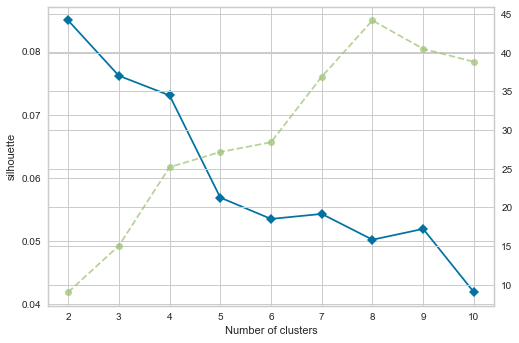

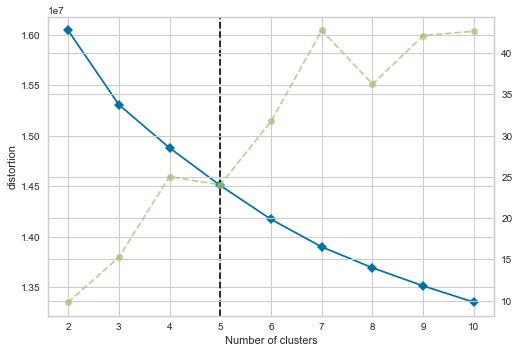

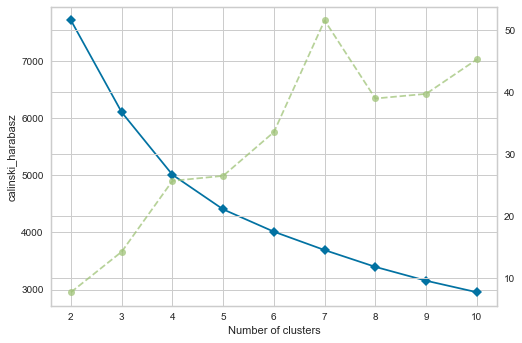

In [102]:
number_clusters(pva_i, KMeans(random_state=0))

In [103]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [105]:
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(pva_i)
df_concat = pd.concat((pva_i, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,TCODE,Age,NUMCHLD,INCOME,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MDMAUD_A_0,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_M,MDMAUD_A_T,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
labels,,,,,,,,,,,,,,,,,,,,,
0.0,-0.007075,-0.001494,-0.005374,-0.002801,0.002032,-0.036768,0.043080,0.039113,-0.012519,0.020846,...,0.997779,0.001832,0.000222,0.000167,0.0,0.000444,0.347954,0.301149,0.165677,0.184776
1.0,-0.003267,-0.029862,-0.003998,-0.010299,-0.013931,-0.022713,0.024102,0.032778,-0.027643,0.028683,...,0.998018,0.001762,0.000110,0.000110,0.0,0.000550,0.342948,0.303094,0.168226,0.185181
2.0,-0.004088,0.001459,-0.006949,0.001760,0.008370,-0.023069,0.045633,0.037863,-0.005110,0.027731,...,0.998410,0.001528,0.000061,0.000000,0.0,0.000611,0.343217,0.302745,0.168063,0.185364
3.0,0.000104,-0.002131,-0.024791,-0.001993,-0.003415,-0.026550,0.027027,0.039125,-0.014798,0.021840,...,0.998256,0.001489,0.000213,0.000043,0.0,0.000468,0.338820,0.304368,0.172047,0.184297
4.0,0.001532,-0.008347,-0.018742,0.003533,-0.019976,-0.020868,0.031861,0.023491,0.003142,0.019890,...,0.998356,0.001644,0.000000,0.000000,0.0,0.000193,0.346392,0.304314,0.167924,0.181176


In [107]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_complete = pva_i.copy()
km_complete["km_labels"] = km_labels

TypeError: annotate() missing 1 required positional argument: 's'

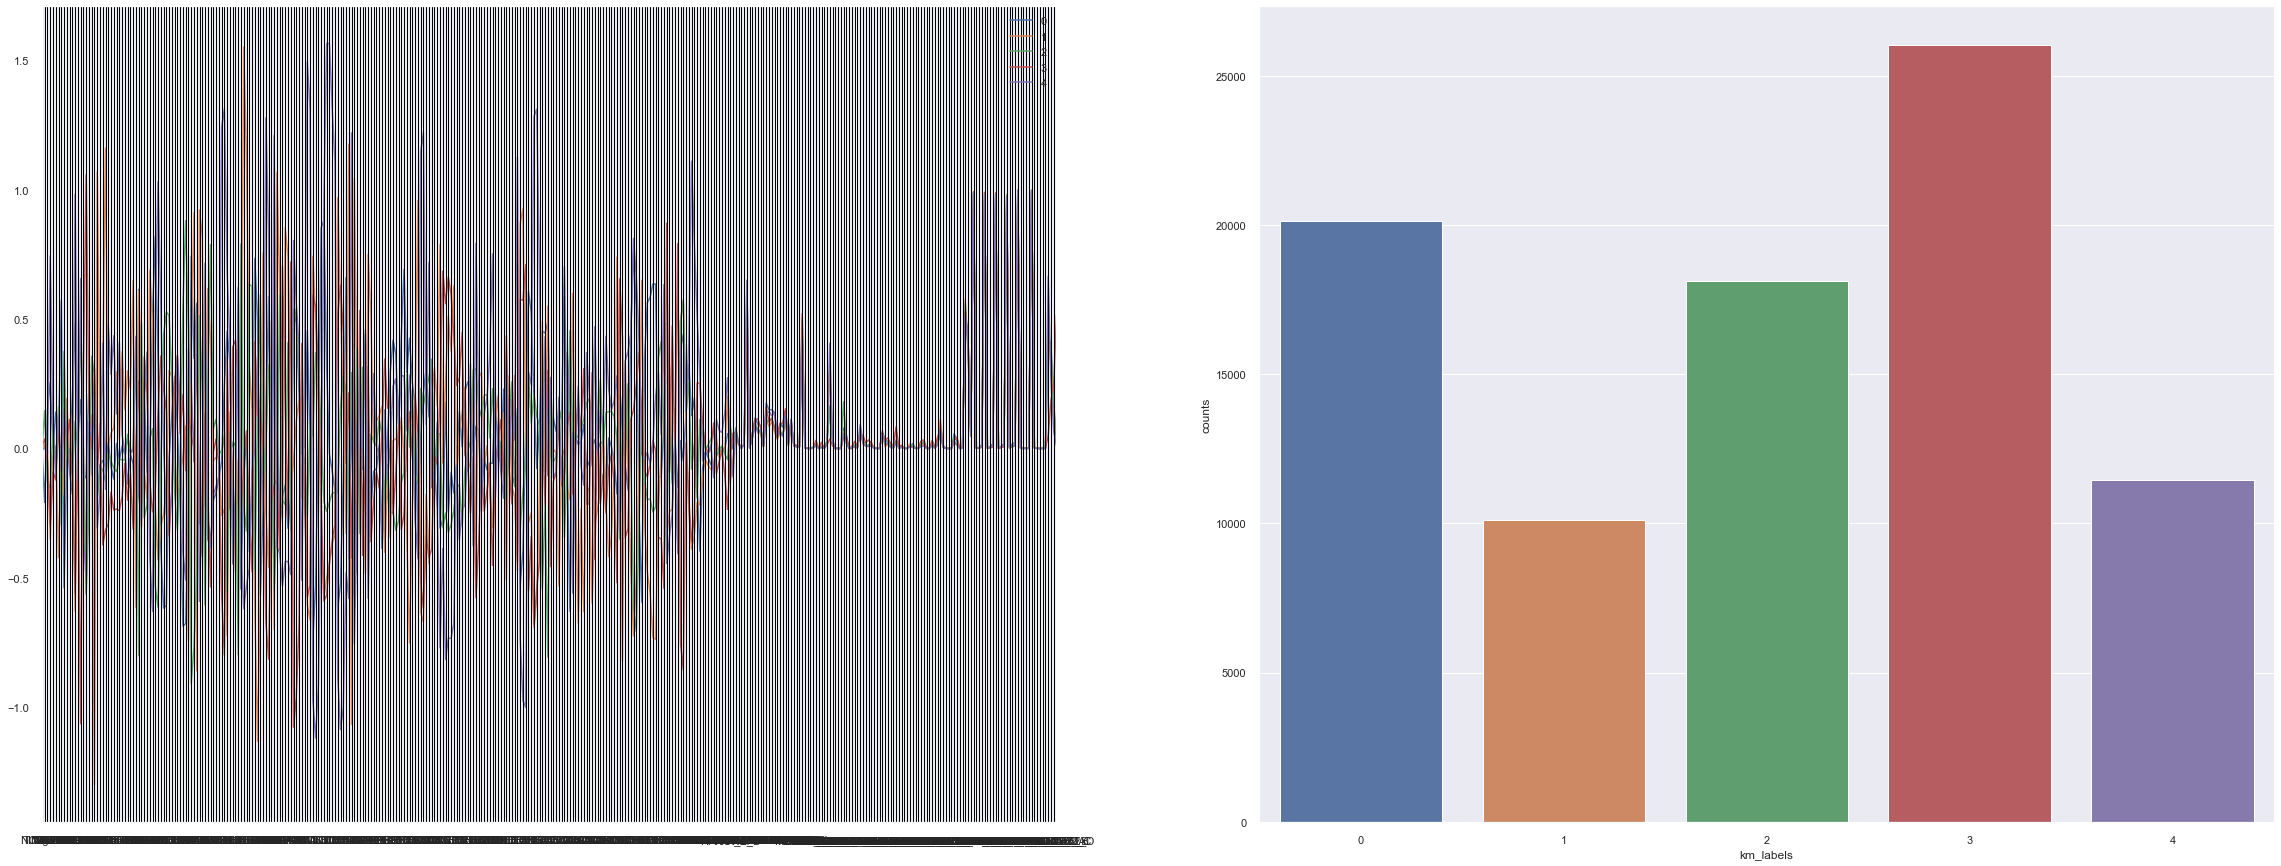

In [108]:
cluster_profiles(km_complete, ["km_labels"],(40,15), compar_titles=None)

In [109]:
pva_out.to_csv('pva_out.csv',sep=';',index=False)